# Model Selection an Evaluation

In [1]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment', None)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import svm 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
combined = pd.read_csv("../Personal Response_to_Resistance/Input Data/clean_data.csv", header=0)
#combined = pd.read_csv('clean_data.csv')
combined.head()

/Users/brinaseidel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_time,date_x,time,loc_t ype,zip_code,council_district,apd_sector,apd_district,latitude,longtitude,...,P0030006_pct,P0030007_pct,P0030008_pct,P0040003_pct,P0200002_pct,P0250002_pct,P0190007_pct,B19113_001E,B17001_001E_pct,C18120_003E_pct
0,2014-10-01 20:19:00,10/01/2014,2019.0,RESIDENCE / HOME,78723.0,1.0,ID,1,30.315506,-97.690678,...,0.0004,0.211769,0.064652,0.529424,0.402545,0.130133,0.337189,35600.0,0.994701,0.88417
1,2014-10-05 16:33:00,10/05/2014,1633.0,RESIDENCE / HOME,78723.0,1.0,ID,1,30.315506,-97.690678,...,0.0004,0.211769,0.064652,0.529424,0.402545,0.130133,0.337189,35600.0,0.994701,0.88417
2,2012-01-20 22:30:00,01/20/2012,2230.0,PARKING LOTS / GARAGE,78723.0,1.0,ID,1,30.320667,-97.687671,...,0.0004,0.211769,0.064652,0.529424,0.402545,0.130133,0.337189,35600.0,0.994701,0.88417
3,2011-01-01 20:00:00,01/01/2011,2000.0,RESIDENCE / HOME,78723.0,1.0,ID,1,30.320667,-97.687671,...,0.0004,0.211769,0.064652,0.529424,0.402545,0.130133,0.337189,35600.0,0.994701,0.88417
4,2012-03-06 05:00:00,03/06/2012,500.0,RESIDENCE / HOME,78723.0,1.0,ID,1,30.320667,-97.687671,...,0.0004,0.211769,0.064652,0.529424,0.402545,0.130133,0.337189,35600.0,0.994701,0.88417


In [3]:
# APD sector
apd_sector_dummies = pd.get_dummies(combined.apd_sector)
cols = []
for col in apd_sector_dummies.columns:
    cols.append("apd_sector"+str(col))
apd_sector_dummies.columns = cols

# Zip codes
zip_dummies = pd.get_dummies(combined.zip_code)
cols = []
for col in zip_dummies.columns:
    cols.append("zip"+str(int(col)))
zip_dummies.columns = cols

combined = pd.concat([combined, apd_sector_dummies, zip_dummies], axis=1)

# Location type
loc_type_dummies = pd.get_dummies(combined['loc_t ype'])
cols = []
for col in loc_type_dummies.columns:
    cols.append("loc_type"+str(col))
loc_type_dummies.columns = cols

combined = pd.concat([combined, apd_sector_dummies, zip_dummies, loc_type_dummies], axis=1)

combined.drop(["month", "day_of_week", "hour_of_day", "tract", "loc_t ype", "apd_sector", "zip_code", "council_district", "latitude", "longtitude", "date_time", "date_x", "apd_district", "location", "year", "time"], axis=1, inplace=True)


In [4]:
# Compare cases with missing data to cases with nonmissing data
print("Cases with missing that we will drop:")
print(combined[combined.isnull().any(axis=1)].Target1.value_counts(normalize=True))
print("\n Nonmissing Cases:")
print(combined[~combined.isnull().any(axis=1)].Target1.value_counts(normalize=True))

# Drop rows with missing data
combined = combined.dropna()
combined.reset_index(inplace=True, drop=True)


Cases with missing that we will drop:
0.0    0.993385
1.0    0.006615
Name: Target1, dtype: float64

 Nonmissing Cases:
0.0    0.987127
1.0    0.012873
Name: Target1, dtype: float64


In [5]:
combined_outcomes = combined[["Target2", "any_weapon", "max_r2r", "any_shot", "any_sub_complaint", "any_off_complaint", "any_resistance"]]
combined.drop(["any_weapon", "max_r2r", "any_shot", "any_sub_complaint", "any_off_complaint", "any_resistance"], axis=1, inplace=True)

In [6]:
# Standardize the data
combined_scaled = pd.DataFrame(StandardScaler().fit_transform(combined))

In [7]:
combined_scaled.columns = combined.columns
combined_scaled.Target1 = (combined_scaled["Target1"]>0).astype(int)
combined_scaled.Target2 = (combined_scaled["Target1"]>1).astype(int)

## Split into training and testing data

In [8]:
X = combined.drop(["Target1", "Target2"], axis=1)
y = combined["Target1"]

# Regular dataset
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, list(combined.index), test_size=0.2, random_state=100, stratify=y)

# Scaled dataset
X_train_scaled = combined_scaled.drop(["Target1", "Target2"], axis=1).iloc[index_train, ]
y_train_scaled = combined.loc[index_train, "Target1"]
X_test_scaled = combined_scaled.drop(["Target1", "Target2"], axis=1).iloc[index_test, ]
y_test_scaled = combined.loc[index_test, "Target1"]

In [9]:
# Check that the stratification worked
print("Training:")
print(y_train.value_counts(normalize=True))
print("\nTesting:")
print(y_test.value_counts(normalize=True))

Training:
0.0    0.987127
1.0    0.012873
Name: Target1, dtype: float64

Testing:
0.0    0.987126
1.0    0.012874
Name: Target1, dtype: float64


## Run a baseline model

Our baseline model uses only the information that was available to the police department before our data mining process. This includes:
- Month dummies
- Day of week dummies
- Hour of day dummies

In [10]:
apd_sectors =  [col for col in combined if col.startswith('apd_sector') and col != "apd_sector"][:-1]
months = [col for col in combined if col.startswith('month') and col != "month"][:-1]
days = [col for col in combined if col.startswith('day') and col != "day_of_week"][:-1]
hours = [col for col in combined if col.startswith('hour') and col != "hour_of_day"][:-1]
baseline_cols = months + days + hours + apd_sectors

In [11]:
model = DecisionTreeClassifier(criterion="entropy").fit(X_train[baseline_cols], y_train)
y_pred = model.predict_proba(X_test[baseline_cols])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.6250091424253844

## Select appropriate features

In [12]:
# Run a logistic regression with a L1 penalty to return zeroes for some coefficients that are not useful
l1_regularization = LogisticRegression(penalty='l1', solver='saga').fit(X_train_scaled, y_train_scaled)

/Users/brinaseidel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [13]:
l1_regularization_coefs = dict(zip(X_train.columns, l1_regularization.coef_[0]))
cols_to_use = [key for key, value in l1_regularization_coefs.items() if value != 0]
print("Variables dropped: " + str(len(X_train.columns) - len(cols_to_use)))
print("Variables remaining: " + str(len(cols_to_use)))

Variables dropped: 121
Variables remaining: 194


In [14]:
# Show largest coefficients
for key, value in l1_regularization_coefs.items():
    l1_regularization_coefs[key] = abs(value)
sorted(l1_regularization_coefs, key=l1_regularization_coefs.get, reverse=True)

['loc_typeSTREETS / HWY / ROAD / ALLEY',
 'hour2',
 'loc_typeRESIDENCE / HOME',
 'hour1',
 'zip78701',
 'loc_typeCOMMERCIAL / OFFICE BUILDING',
 'hour12',
 'loc_typePARK / PLAYGROUND',
 'hour8',
 'hour9',
 'day6',
 'P0030004_pct',
 'B19113_001E',
 'apd_sectorID',
 'hour10',
 'loc_typeDEPARTMENT / DISCOUNT STORE',
 'C18120_003E_pct',
 'hour11',
 'loc_typePARKING LOTS / GARAGE',
 'apd_sectorGE',
 'hour14',
 'loc_typeOTHER / UNKNOWN',
 'hour4',
 'P0190007_pct',
 'zip78752',
 'loc_typeGROCERY / SUPERMARKET',
 'loc_typeDRUG STORE / DR. OFFICE / HOSPITAL',
 'zip78753',
 'day5',
 'apd_sectorAD',
 'P0030005_pct',
 'hour13',
 'P0250002_pct',
 'zip78751',
 'loc_typeRESTAURANTS',
 'P0130003',
 'hour3',
 'apd_sectorCH',
 'hour18',
 'day1',
 'apd_sectorED',
 'loc_typeGOVERNMENT / PUBLIC BUILDING',
 'hour0',
 'hour7',
 'apd_sectorBA',
 'day3',
 'zip78703',
 'zip78704',
 'loc_typeFIELD / WOODS',
 'P0030008_pct',
 'zip78746',
 'loc_typeCONSTRUCTION SITE',
 'hour17',
 'day0',
 'P0130001',
 'hour22',
 '

In [15]:
cols_to_use

['temp_max',
 'temp_avg',
 'temp_min',
 'dew_max',
 'dew_avg',
 'dew_min',
 'hum_max',
 'hum_min',
 'wind_max',
 'wind_min',
 'pres_max',
 'pres_min',
 'prec_avg',
 'new_year',
 'mlk_day',
 'wash_bday',
 'mem_day',
 'ind_day',
 'labor_day',
 'col_day',
 'vet_day',
 'thanksgiving',
 'christmas',
 'month1',
 'month2',
 'month3',
 'month4',
 'month5',
 'month6',
 'month7',
 'month8',
 'month9',
 'month10',
 'month11',
 'month12',
 'day0',
 'day1',
 'day2',
 'day3',
 'day4',
 'day5',
 'day6',
 'hour0',
 'hour1',
 'hour2',
 'hour3',
 'hour4',
 'hour5',
 'hour6',
 'hour7',
 'hour8',
 'hour9',
 'hour10',
 'hour11',
 'hour12',
 'hour13',
 'hour14',
 'hour15',
 'hour16',
 'hour17',
 'hour18',
 'hour19',
 'hour20',
 'hour21',
 'hour22',
 'hour23',
 'P0030001',
 'P0130001',
 'P0130002',
 'P0130003',
 'P0030002_pct',
 'P0030003_pct',
 'P0030004_pct',
 'P0030005_pct',
 'P0030006_pct',
 'P0030007_pct',
 'P0030008_pct',
 'P0040003_pct',
 'P0200002_pct',
 'P0250002_pct',
 'P0190007_pct',
 'B19113_001E

## Run models on training data

In [16]:
# Set up stratified k fold split
skf = StratifiedKFold(n_splits=5, random_state=400)
skf.get_n_splits(X_train, y_train)

5

In [17]:
# Logistic regression 
auc_lr = []
for train_index, test_index in skf.split(X_train, y_train):
    
    X_train_fold, X_test_fold = X_train[cols_to_use].iloc[train_index], X_train[cols_to_use].iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = LogisticRegression(C=1e30).fit(X_train_fold, y_train_fold)
    
    y_pred_fold = model.predict_proba(X_test_fold)[:,1]
    fpr1, tpr1, thresholds = roc_curve(y_test_fold, y_pred_fold)
    auc_lr.append(auc(fpr1, tpr1))

np.mean(auc_lr)

0.5997927511302519

In [18]:
# Naive bayes
auc_nb = []
for train_index, test_index in skf.split(X_train, y_train):
        
    X_train_fold, X_test_fold = X_train[cols_to_use].iloc[train_index], X_train[cols_to_use].iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = BernoulliNB().fit(X_train_fold, y_train_fold)
    
    y_pred_fold = model.predict_proba(X_test_fold)[:,1]
    fpr2, tpr2, thresholds = roc_curve(y_test_fold, y_pred_fold)
    auc_nb.append(auc(fpr2, tpr2))

np.mean(auc_nb)

0.7179777081580243

In [19]:
# Decision tree
auc_dt = []
for train_index, test_index in skf.split(X_train, y_train):
    
    X_train_fold, X_test_fold = X_train[cols_to_use].iloc[train_index], X_train[cols_to_use].iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = DecisionTreeClassifier(criterion="entropy").fit(X_train_fold, y_train_fold)
    
    y_pred_fold = model.predict_proba(X_test_fold)[:,1]
    fpr3, tpr3, thresholds = roc_curve(y_test_fold, y_pred_fold)
    auc_dt.append(auc(fpr3, tpr3))

np.mean(auc_dt)

0.554751166088742

In [20]:
# KNN
auc_knn = []
for train_index, test_index in skf.split(X_train, y_train):
    
    X_train_fold, X_test_fold = X_train[cols_to_use].iloc[train_index], X_train[cols_to_use].iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = KNeighborsClassifier(n_neighbors=5).fit(X_train_fold, y_train_fold)
                                       
    y_pred_fold = model.predict_proba(X_test_fold)[:,1]
    fpr4, tpr4, thresholds = roc_curve(y_test_fold, y_pred_fold)
    auc_knn.append(auc(fpr4, tpr4))

np.mean(auc_knn)

0.6007450487322166

In [21]:
# SVM - THIS DOESN"T WORK (in a reasonable amount of time)!
#auc_svm = []
#for train_index, test_index in skf.split(X_train, y_train):
        
#    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
#    svm_model = svm.SVC(kernel='linear')
#    svm_model.fit(X_train_fold, y_train_fold)
    
#    y_pred_fold = svm.predict_proba(X_test_fold)[:,1]
#    fpr, tpr, thresholds = roc_curve(y_test_fold, y_pred_fold)
#    auc_svm.append(auc(fpr, tpr))


To compare the four models that ran beyond the AUC values, we plot the ROC curve. 

<Figure size 1008x720 with 0 Axes>

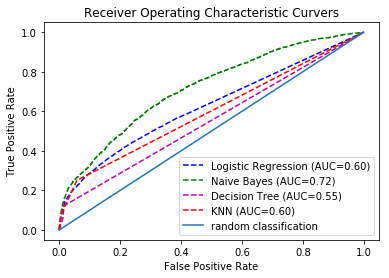

<Figure size 1008x720 with 0 Axes>

In [22]:
plt.title('Receiver Operating Characteristic Curvers')
plt.plot(fpr, tpr, 'b--', label = 'Logistic Regression (AUC=%0.2f)' % np.mean(auc_lr)) #logistic regression
plt.plot(fpr2, tpr2, 'g--', label = 'Naive Bayes (AUC=%0.2f)' % np.mean(auc_nb)) #naive bayes
plt.plot(fpr3, tpr3, 'm--', label = 'Decision Tree (AUC=%0.2f)' % np.mean(auc_dt)) #decision tree
plt.plot(fpr4, tpr4, 'r--', label = 'KNN (AUC=%0.2f)' %np.mean(auc_knn)) #KNN
plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1, 0.1), label = 'random classification')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.figure(figsize=(14, 10),)

## Tune the Naive Bayes model

In [23]:
# Naive bayes
auc_nb = {}
alphaoptions = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
for val in alphaoptions:
    auc_nb[val] = []
    
for train_index, test_index in skf.split(X_train, y_train):
    
    X_train_fold, X_test_fold = X_train[cols_to_use].iloc[train_index], X_train[cols_to_use].iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    for i in alphaoptions:
        
        model = BernoulliNB(alpha=i).fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict_proba(X_test_fold)[:,1]
        fpr2, tpr2, thresholds = roc_curve(y_test_fold, y_pred_fold)
        auc_nb[i].append(auc(fpr2, tpr2))

In [24]:
averagenb = []
for entry in auc_nb:
    averagenb.append(np.mean(auc_nb[entry]))

bestalpha = list(auc_nb.keys())[averagenb.index(max(averagenb))]
print(bestalpha)

1


Text(0.5,0,'alpha')

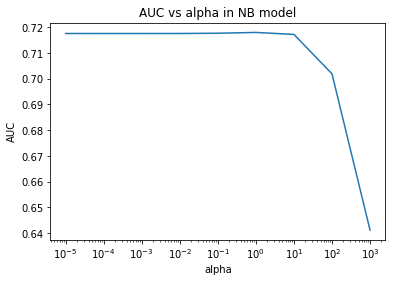

In [25]:
plt.semilogx(alphaoptions, averagenb)
plt.title('AUC vs alpha in NB model')
plt.ylabel('AUC')
plt.xlabel('alpha')

## Run the final model and evaluate it

In [26]:
model = BernoulliNB().fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
fpr_final, tpr_final, thresholds = roc_curve(y_test, y_pred)
final_auc = auc(fpr2, tpr2)
print(final_auc)

0.6405166223599


In [27]:
# Show the confusion matrix at different thresholds 
n = y_test.shape[0]
thresholds=range(1, 100)
thresholds = [x/100 for x in thresholds]
accuracy = []
recall = []
for threshold in thresholds:
    y_pred_class = y_pred > threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
    #print("Threshold: " + str(threshold))
    #print("False positive rate: " + str(fp/(tp+fp)))
    #print("False negative rate: " + str(fn/(tn+fn)))    
    #print("Accuracy: " + str((tp+tn)/(tp+tn+fp+fn)))
    recall.append(tp/(tp+fn))
    accuracy.append((tp+tn)/(tp+tn+fp+fn))
metrics = pd.DataFrame({"threshold": thresholds,
                       "accuracy": accuracy,
                       "recall": recall})    

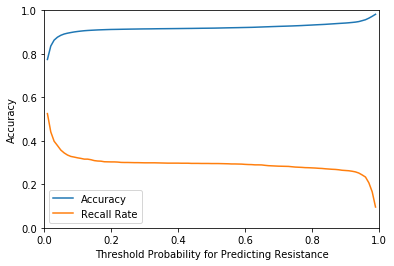

In [28]:
plt.plot(metrics.threshold, metrics.accuracy, label="Accuracy")
plt.plot(metrics.threshold, metrics.recall, label="Recall Rate")
#plt.axvline(x=0.02)
plt.ylabel("Accuracy")
plt.xlabel("Threshold Probability for Predicting Resistance")
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)
plt.legend()

(0.0, 1)

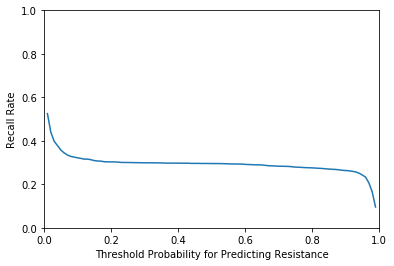

In [29]:
plt.plot(metrics.threshold, metrics.recall)
plt.ylabel("Recall Rate")
plt.xlabel("Threshold Probability for Predicting Resistance")
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)

threshold    0.030000
accuracy     0.863114
recall       0.398120
Name: 2, dtype: float64


Text(83.4,0.5,'True Value')

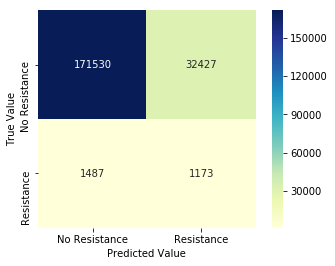

In [30]:
y_pred_class = y_pred > 0.02
print(metrics.iloc[2, ])
conf_mat= confusion_matrix(y_test, y_pred_class)
sns.heatmap(conf_mat, fmt='d',square=True, annot=True, cmap="YlGnBu",  xticklabels = ['No Resistance','Resistance'],
                                                           yticklabels = ['No Resistance','Resistance'])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

In [31]:
# Merge in the remaining outcome variables
combined_outcomes_test = combined_outcomes.iloc[index_test]
combined_outcomes_test["y_pred_class"] = y_pred_class
combined_outcomes_test["y_true"] = y_test

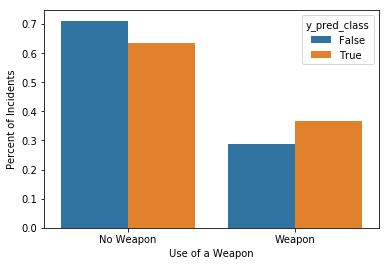

In [32]:
combined_outcomes_test["any_weapon_str"] = ""
combined_outcomes_test.loc[combined_outcomes_test.any_weapon == 1, "any_weapon_str"] = "Weapon"
combined_outcomes_test.loc[combined_outcomes_test.any_weapon == 0, "any_weapon_str"] = "No Weapon"
ct=pd.crosstab(combined_outcomes_test.loc[combined_outcomes_test.y_true==1, ].y_pred_class, combined_outcomes_test.loc[combined_outcomes_test.y_true==1, ].any_weapon_str).apply(lambda r: r/r.sum(), axis=1)
stacked = ct.stack().reset_index().rename(columns={0:'value'})
fig = sns.barplot(x=stacked.any_weapon_str, y=stacked.value, hue=stacked.y_pred_class)
fig.set(xlabel='Use of a Weapon', ylabel='Percent of Incidents')
plt.show()


In [33]:
ct

any_weapon_str,No Weapon,Weapon
y_pred_class,,
False,0.711500,0.288500
True,0.633419,0.366581


## Make Summary Statistics Table

In [34]:
combined.describe().to_csv("Output Data/Summary Stats.csv")